# Exploring Banking Data Using PySpark

## Objective:
- The objective from this project is to create a <b>classifier to predict whether the client will subscribe (Yes/No) to a term deposit</b>.
- It is required to obtain <b>AUC > 0.85</b>.
- We'll use a dataset from UCI Repository. Bank Marketing:<br>
https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

### Create a spark session and import the required libraries

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark  = SparkSession.builder.getOrCreate()
import pyspark.sql.functions as pysFnc

### Read the data into a DataFrame

In [142]:
df = spark.read.format('csv').option('header','true').option('inferSchema','true').load('bank.csv')

### Print the schema

In [143]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



### Show the first 5 rows from the dataframe

In [145]:
df.show(5,truncate=True)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|    admin.|married| tertiary|     no|    184|     no|  no|unknown|  5| 

## Exploring Data Analytics

In [37]:
df.groupBy('deposit').count().toPandas()

,deposit,count
0,no,5873
1,yes,5289


In [146]:
quantitative_features = [item[0] for item in df.dtypes if item[1]=='int']
df.select(quantitative_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


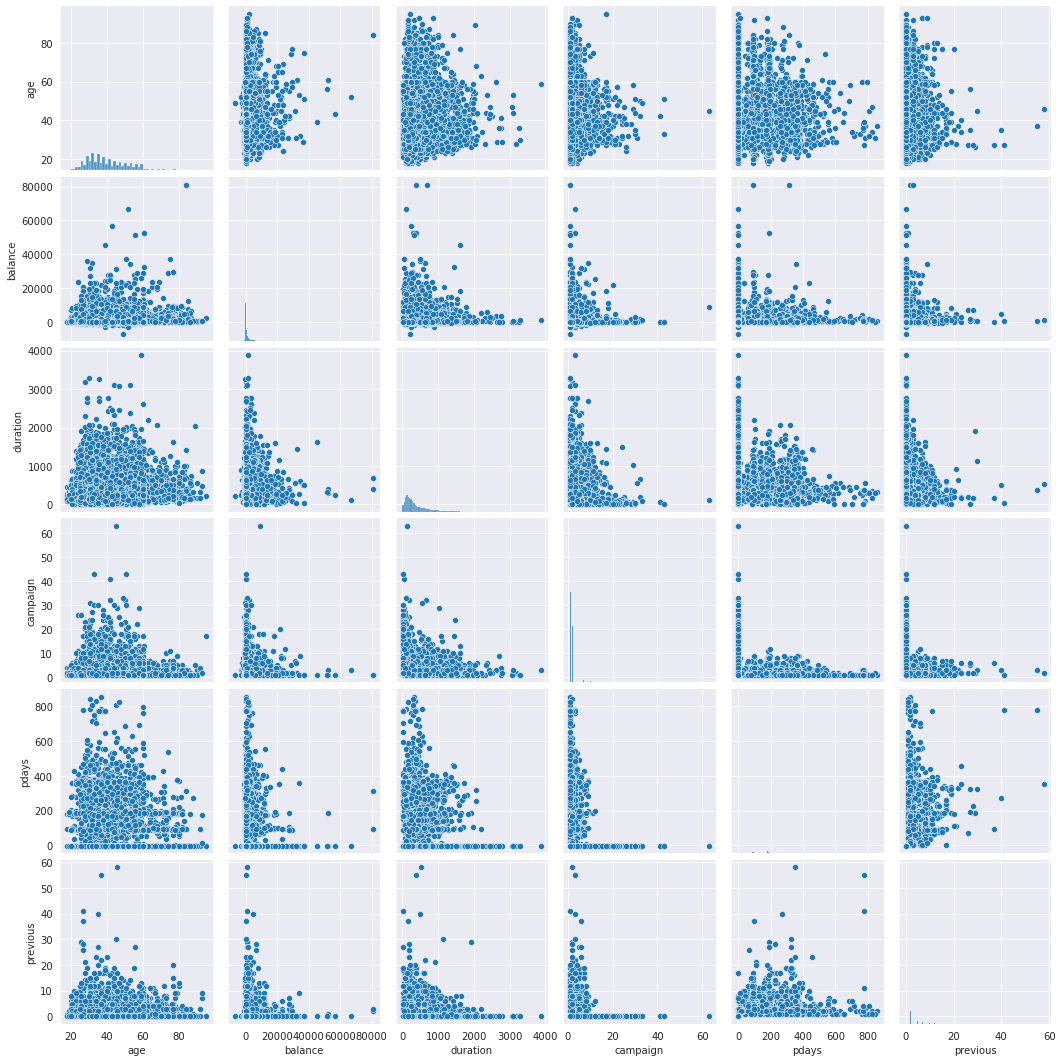

In [73]:
quantitative_df = df.select(quantitative_features).toPandas()
sns.pairplot(quantitative_df);

In [74]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



## Feature Transformations

### Perform the following steps to obtain TF-IDF:
1. Import the required transformers/estimators for the subsequent steps.
2. Create a <b>StringIndexer</b> for the categorical columns and target column.
3. Create a <b>OneHotEncoder</b> to convert the <b>indexed columns</b> to one-hot encoded columns.
4. Create a <b>VectorAssembler</b> after enocding the features.

In [76]:
from pyspark.ml.feature import OneHotEncoder,StringIndexer, VectorAssembler
categorical_features = [item[0] for item in df.dtypes if item[1]=='string']
categorical_features.remove('deposit')

categorical_indexed = [f'{col}_index' for col in categorical_features]
categorical_encoded = [f'{col}_oh_encoded' for col in categorical_features] 
stringIndexer = StringIndexer(inputCols=categorical_features,outputCols=categorical_indexed)
oh_encoder = OneHotEncoder(inputCols=categorical_indexed, outputCols=categorical_encoded)
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')


input_features = categorical_encoded + quantitative_features
assembler = VectorAssembler(inputCols=input_features, outputCol="features")

## Pipeline
### Create a pipeline model contains all the steps of preprocessing.

In [78]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stringIndexer,oh_encoder,label_stringIdx,assembler])
preprocessing = pipeline.fit(df)
modefied_df = preprocessing.transform(df)

In [81]:
train, test = modefied_df.randomSplit([0.7,0.3],seed=42)
print(f"Training Dataset Count: {train.count()}")
print(f"Testing Dataset Count: {test.count()}")

Training Dataset Count: 7901
Testing Dataset Count: 3261


## **Modeling**

### **1. Logistic Regression**

In [84]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features',labelCol='label',maxIter=10)
reg_model = lr.fit(train)

training AUC: 0.892391384702415


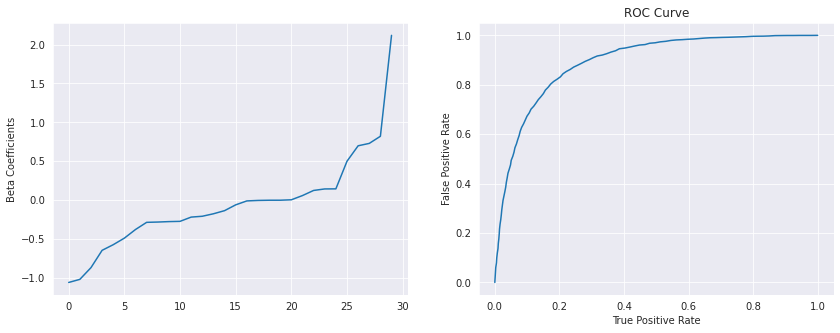

In [133]:
beta = np.sort(reg_model.coefficients)
fig = plt.figure(figsize=(14,5))
ax_1 = fig.add_subplot(121)
ax_1.plot(beta)
ax_1.set_ylabel('Beta Coefficients')

ax_2 = fig.add_subplot(122)
trainingSummary = reg_model.summary
roc = trainingSummary.roc.toPandas()
ax_2.plot(roc['FPR'],roc['TPR'])
ax_2.set_ylabel('False Positive Rate')
ax_2.set_xlabel('True Positive Rate')
ax_2.set_title('ROC Curve')
# plt.show()
print('training AUC: ' + str(trainingSummary.areaUnderROC))

In [134]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions = reg_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print('Test AUC', evaluator.evaluate(predictions))

Test AUC 0.8692715150939689


### **2. Decision Tree Classifier**

In [135]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol='features',labelCol='label',maxDepth=6)
dt_model = dt.fit(train)

In [136]:
predictions = dt_model.transform(test)
print("Test AUC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test AUC: 0.7749034090009925


### **3. RandomForestClassifier**

In [126]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rf_model = rf.fit(train)

In [127]:
predictions = rf_model.transform(test)
print("Test AUC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test AUC: 0.8652671427828602


### **4. Gradient Boosted Tree Classifier** 

In [128]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbt_model = gbt.fit(train)

In [129]:
predictions = gbt_model.transform(test)
print("Test AUC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test AUC: 0.868965370421866


## **Tunining**

In [122]:
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth,[2,4,6])
             .addGrid(gbt.maxBins,[20,60])
             .addGrid(gbt.maxIter,[10,20])
             .build())

cv = CrossValidator(estimator=gbt,estimatorParamMaps=paramGrid,evaluator=evaluator,numFolds=5)
cv_model=cv.fit(train)

Test AUC: 0.873662854270616


In [ ]:
predictions = cv_model.transform(test)
print("Test AUC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))